In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('chargeback_dataset.csv')

# view the dataset
df.head(10)

,Unnamed: 0,Card Number,Date,Amount,CBK
0,0,536518******2108,2015-05-01 00:01:54,36.54,No
1,1,536518******2108,2015-05-01 00:03:46,36.54,No
2,2,453211******1239,2015-05-01 00:08:50,69.00,No
3,3,548827******1705,2015-05-01 00:27:00,193.43,No
4,4,531681******9778,2015-05-01 01:32:46,132.00,No
5,5,515117******4107,2015-05-01 02:10:26,161.00,No
6,6,432032******9111,2015-05-01 08:09:15,110.00,No
7,7,544540******7141,2015-05-01 08:30:16,159.50,No
8,8,554906******0358,2015-05-01 09:13:51,126.50,Yes
9,9,554906******0358,2015-05-01 09:15:28,126.50,Yes


In [3]:
# Remove * from card numbers
df['Card Number'] = df['Card Number'].str.replace('*', '')

# Drop the serial numbers column
df.drop(df.columns[0], axis=1, inplace=True)

# Convert 'Yes' and 'No' class labels to 1 and 0 respectively
df['CBK'] = df['CBK'].map({'Yes': 1, 'No': 0})

<ipython-input-3-c62b374053f7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Card Number'] = df['Card Number'].str.replace('*', '')


In [4]:
# Convert date string to Pandas datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract the day of the week
df['day_of_week'] = df['Date'].dt.day_name()

In [5]:
# Preprocessing for day of the week by mapping each day to a number
df['day_of_week_in_num'] = df['day_of_week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})

# Creating 2 new features to capture information on day of the week
df['day_of_week_sin'] = np.sin(df['day_of_week_in_num'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week_in_num'] * (2 * np.pi / 7))

In [6]:
# Preprocessing for time of transaction

# Extract the earliest date
mindate = df['Date'].min()

# Create a new feature for time of transaction and drop the day column
df['Timestamp in Seconds'] = (df['Date'] - mindate).dt.total_seconds()
df.drop(columns=['Date'], inplace=True)

In [7]:
# Creating new features

# Calculate the average time difference between consecutive transactions for each unique Card Number
df['Card Frequency'] = df.groupby('Card Number')['Timestamp in Seconds'].transform(lambda x: x.diff().mean()).fillna(0)

# Calculate the average amount per transaction for each unique Card Number
df['AmountPerTransactionFrequency'] = df['Amount'] / df.groupby('Card Number')['Timestamp in Seconds'].transform('count')

df['TimeBetweenTransactions'] = df.groupby('Card Number')['Timestamp in Seconds'].diff().fillna(0)

# Calculate the average time per transaction for each card
df['AverageTimeBetweenTransaction'] = df.groupby('Card Number')['TimeBetweenTransactions'].transform('mean').fillna(0)

In [8]:
# Scale the features
from sklearn.preprocessing import MinMaxScaler

# instantiate MinMaxScaler
#scaler = MinMaxScaler()

# Extract numerical columns for scaling
#numerical_columns = ['Amount', 'day_of_week_sin', 'day_of_week_cos', 'Timestamp in Seconds','Card Frequency', 'AmountPerTransactionFrequency', 'TimeBetweenTransactions', 'AverageTimeBetweenTransaction']

# Apply min-max scaling to numerical columns
#df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)

# Combine the columns
#df_result = pd.concat([df.drop(columns=numerical_columns), df_scaled], axis=1)

In [9]:
# Scale the features
from sklearn.preprocessing import StandardScaler

# instantiate MinMaxScaler
scaler = StandardScaler()

# Extract numerical columns for scaling
numerical_columns = ['Amount', 'day_of_week_sin', 'day_of_week_cos', 'Timestamp in Seconds','Card Frequency', 'AmountPerTransactionFrequency', 'TimeBetweenTransactions', 'AverageTimeBetweenTransaction']

# Apply min-max scaling to numerical columns
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)

# Combine the columns
df_result = pd.concat([df.drop(columns=numerical_columns), df_scaled], axis=1)

In [10]:
df_result.head()

,Card Number,CBK,day_of_week,day_of_week_in_num,Amount,day_of_week_sin,day_of_week_cos,Timestamp in Seconds,Card Frequency,AmountPerTransactionFrequency,TimeBetweenTransactions,AverageTimeBetweenTransaction
0,5365182108,0,Friday,4,-0.657772,-0.766363,-1.024399,-1.894535,-0.314045,-0.693506,-0.216572,-0.324566
1,5365182108,0,Friday,4,-0.657772,-0.766363,-1.024399,-1.894379,-0.314045,-0.693506,-0.216090,-0.324566
2,4532111239,0,Friday,4,-0.428237,-0.766363,-1.024399,-1.893956,-0.314428,-0.297555,-0.216572,-0.324928
3,5488271705,0,Friday,4,0.451644,-0.766363,-1.024399,-1.892439,-0.314428,0.673629,-0.216572,-0.324928
4,5316819778,0,Friday,4,0.017255,-0.766363,-1.024399,-1.886946,-0.314428,0.194164,-0.216572,-0.324928


In [11]:
X = df_result[['Card Number', 'Amount', 'day_of_week_sin', 'day_of_week_cos', 'Timestamp in Seconds', 'Card Frequency', 'AmountPerTransactionFrequency', 'TimeBetweenTransactions', 'AverageTimeBetweenTransaction']]
y = df_result['CBK']

In [12]:
# split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
# Apply SMOTE-NC to the training data
smoteNC = SMOTENC(categorical_features = [0, 2, 3], random_state=42, sampling_strategy = 0.9)
X_train, y_train = smoteNC.fit_resample(X_train, y_train)

In [14]:
print(pd.Series(y_train).value_counts())

0    8440
1    7596
Name: CBK, dtype: int64


In [15]:
LDAmodel = LinearDiscriminantAnalysis()
LDAmodel.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [16]:
y_pred_LDA = LDAmodel.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix

accuracy_LDA = accuracy_score(y_test, y_pred_LDA)
precision_LDA = precision_score(y_test, y_pred_LDA)
recall_LDA = recall_score(y_test, y_pred_LDA)
f1_LDA = f1_score(y_test, y_pred_LDA)
auc_LDA = roc_auc_score(y_test, y_pred_LDA)

cnf_matrix_LDA = confusion_matrix(y_test, y_pred_LDA)
print('Confusion Matrix - LDA')
print(cnf_matrix_LDA)
print()
print('Classification Report - LDA')
print(classification_report(y_test, y_pred_LDA))

print('Accuracy: ',accuracy_LDA)
print('Precision: ', precision_LDA)
print('Recall: ', recall_LDA)
print('f1 score: ', f1_LDA)
print('ROC AUC Curve: ', auc_LDA)

Confusion Matrix - LDA
[[2004  111]
 [  33   78]]

Classification Report - LDA
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2115
           1       0.41      0.70      0.52       111

    accuracy                           0.94      2226
   macro avg       0.70      0.83      0.74      2226
weighted avg       0.96      0.94      0.94      2226

Accuracy:  0.9353099730458221
Precision:  0.4126984126984127
Recall:  0.7027027027027027
f1 score:  0.52
ROC AUC Curve:  0.8251102165995783


ROC curve for LDA


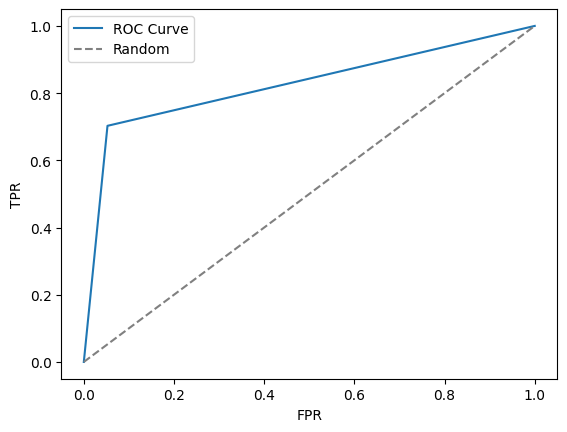

In [18]:
from sklearn.metrics import roc_curve

print("ROC curve for LDA")
fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(y_test, y_pred_LDA)
plt.plot(fpr_LDA, tpr_LDA, label='ROC Curve')
plt.plot([0,1],[0,1], linestyle='--', label='Random', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [19]:
QDAmodel = QuadraticDiscriminantAnalysis(reg_param = 0.65)
QDAmodel.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(reg_param=0.65)

In [20]:
y_pred_QDA = QDAmodel.predict(X_test)

In [21]:
accuracy_QDA = accuracy_score(y_test, y_pred_QDA)
precision_QDA = precision_score(y_test, y_pred_QDA)
recall_QDA = recall_score(y_test, y_pred_QDA)
f1_QDA = f1_score(y_test, y_pred_QDA)
auc_QDA = roc_auc_score(y_test, y_pred_QDA)

cnf_matrix_QDA = confusion_matrix(y_test, y_pred_QDA)
print('Confusion Matrix - QDA')
print(cnf_matrix_QDA)
print()
print('Classification Report - QDA')
print(classification_report(y_test, y_pred_QDA))

print('Accuracy: ',accuracy_QDA)
print('Precision: ', precision_QDA)
print('Recall: ', recall_QDA)
print('f1 score: ', f1_QDA)
print('ROC AUC Curve: ', auc_QDA)

Confusion Matrix - QDA
[[1312  803]
 [  31   80]]

Classification Report - QDA
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      2115
           1       0.09      0.72      0.16       111

    accuracy                           0.63      2226
   macro avg       0.53      0.67      0.46      2226
weighted avg       0.93      0.63      0.73      2226

Accuracy:  0.6253369272237197
Precision:  0.09060022650056625
Recall:  0.7207207207207207
f1 score:  0.16096579476861167
ROC AUC Curve:  0.6705258449939302


ROC curve for QDA


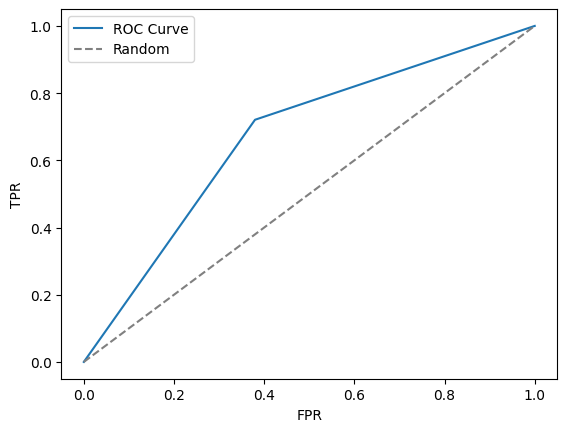

In [22]:
print("ROC curve for QDA")
fpr_QDA, tpr_QDA, thresholds_QDA = roc_curve(y_test, y_pred_QDA)
plt.plot(fpr_QDA, tpr_QDA, label='ROC Curve')
plt.plot([0,1],[0,1], linestyle='--', label='Random', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()